In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import os
load_dotenv()
PROJECT_ROOT = os.getenv('PROJECT_ROOT')

# Add PROJECT_ROOT to the Python path
import sys
sys.path.append(PROJECT_ROOT)

import numpy as np 
import networkx as nx

In [2]:
# Load the comprehensive route graph
import time 
time_start = time.time()
print('Reading navigation graph...')
G = nx.read_gml(os.path.join(PROJECT_ROOT, 'data', 'graphs', 'ats_fra_nodes_only.gml'))
print(f'Navigation graph loaded in {time.time() - time_start:.2f} seconds')
print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')


Reading navigation graph...
Navigation graph loaded in 1.26 seconds
Number of nodes: 33763
Number of edges: 0


In [3]:
import pandas as pd
routes_df = pd.read_csv(os.path.join(PROJECT_ROOT, 'data', 'routes_data', 'cs_2023-04-01.csv'))
# column names: id	from_time	to_time	from_lat	from_lon	to_lat	to_lon	from_alt	to_alt	from_speed	to_speed
routes_df.head()

,id,from_time,to_time,from_lat,from_lon,to_lat,to_lon,from_alt,to_alt,from_speed,to_speed
0,000042HMJ225,1.680349e+09,1.680365e+09,42.941666,14.271751,46.177048,14.543554,11521.44,1569.72,0.232055,0.139918
1,000042HMJ225,1.680365e+09,1.680383e+09,46.177048,14.543554,35.847458,14.489973,1569.72,114.30,0.139918,0.000000
2,001260TC T124,1.680347e+09,1.680347e+09,40.781622,26.631546,40.737488,26.461792,4297.68,4876.80,0.031492,0.031096
3,001260TC T124,1.680347e+09,1.680348e+09,40.737488,26.461792,40.717529,26.377625,4876.80,5242.56,0.031096,0.029558
4,001260TC T124,1.680348e+09,1.680348e+09,40.717529,26.377625,40.729298,26.257761,5242.56,5486.40,0.029558,0.046496


In [4]:
flight_ids = routes_df['id'].unique()
print(f'There are {len(flight_ids)} unique flight ids in the routes data')
selected_flight_id = '0100A3MSR560'
print(f'Selected flight id: {selected_flight_id}')
selected_flight_df = routes_df[routes_df['id'] == selected_flight_id]
print(f'Selected flight df: {selected_flight_df.head()}')

There are 23947 unique flight ids in the routes data
Selected flight id: 0100A3MSR560
Selected flight df:               id     from_time       to_time   from_lat   from_lon     to_lat  \
56  0100A3MSR560  1.680319e+09  1.680319e+09  34.798822  27.681713  34.909570   
57  0100A3MSR560  1.680319e+09  1.680325e+09  34.909570  27.617397  45.970614   
58  0100A3MSR560  1.680325e+09  1.680329e+09  45.970614  18.859474  50.442444   
59  0100A3MSR560  1.680329e+09  1.680330e+09  50.442444  10.632019  50.968183   
60  0100A3MSR560  1.680330e+09  1.680330e+09  50.968183   8.138351  50.937040   

       to_lon  from_alt    to_alt  from_speed  to_speed  
56  27.617397  12306.30  12306.30    0.227358  0.225809  
57  18.859474  12306.30  12047.22    0.225809  0.235399  
58  10.632019  12047.22   9570.72    0.235399  0.235305  
59   8.138351   9570.72   2926.08    0.235305  0.160455  
60   7.379074   2926.08    967.74    0.160455  0.082072  


In [5]:
from tqdm import tqdm
GC = G.copy()

In [6]:
from infer_route4 import process_flight_segments

final_route, new_nodes = process_flight_segments(GC, selected_flight_df, error_threshold=7.)

In [7]:
from infer_route5 import consolidate_nodes
final_route, new_nodes = consolidate_nodes(final_route, new_nodes)

In [8]:
final_route, new_nodes

([('_SyOU0IRm', '_Zli4xeX5', 7.36581630112129),
  ('_Zli4xeX5', 'BABIT', 770.7071700690087),
  ('BABIT', 'PILAM', 425.40388735705415),
  ('PILAM', '_8AEBgVes', 102.92695161172223),
  ('_8AEBgVes', 'TANJO', 26.36114002485334),
  ('_yaCS3W8M', '_CwQgiHS2', 6.977869215813191),
  ('_CwQgiHS2', 'EDDK', 2.9373898647274914)],
 {'_SyOU0IRm': {'lat': 34.79882191803495, 'lon': 27.681713104248047},
  '_Zli4xeX5': {'lat': 34.9095696918035, 'lon': 27.61739730834961},
  '_8AEBgVes': {'lat': 50.96818309719279, 'lon': 8.138351440429688},
  '_yaCS3W8M': {'lat': 50.937039650092686, 'lon': 7.379074096679687},
  '_CwQgiHS2': {'lat': 50.887042546676376, 'lon': 7.212677001953125}})

In [9]:
from infer_route5 import find_best_waypoint_for_data_capture

best_starting_point, best_starting_score = find_best_waypoint_for_data_capture(GC, (selected_flight_df.iloc[0]['from_lat'], selected_flight_df.iloc[0]['from_lon']), (selected_flight_df.iloc[0]['to_lat'], selected_flight_df.iloc[0]['to_lon']), prefer_endpoint='A')
print(f'Best starting point: {best_starting_point}, score: {best_starting_score}')

Best starting point: GUDIS, score: 16.346816492449896


In [10]:
# Add the waypoint to the final_route
ffinal_route = final_route.copy()
ffinal_route.insert(0, (best_starting_point, '__XXX__', 0))
print(ffinal_route)


[('GUDIS', '__XXX__', 0), ('_SyOU0IRm', '_Zli4xeX5', 7.36581630112129), ('_Zli4xeX5', 'BABIT', 770.7071700690087), ('BABIT', 'PILAM', 425.40388735705415), ('PILAM', '_8AEBgVes', 102.92695161172223), ('_8AEBgVes', 'TANJO', 26.36114002485334), ('_yaCS3W8M', '_CwQgiHS2', 6.977869215813191), ('_CwQgiHS2', 'EDDK', 2.9373898647274914)]


In [11]:
from infer_route5 import extract_real_waypoints

# Test the function with the final route
real_waypoints = extract_real_waypoints(ffinal_route, distance_threshold=20, skip_synthetic_waypoints=True)
real_full_waypoints = extract_real_waypoints(ffinal_route, distance_threshold=20, skip_synthetic_waypoints=False)
print("Real waypoints in the route:", real_waypoints)
print("Real full waypoints in the route:", real_full_waypoints)

Real waypoints in the route: ['GUDIS', 'BABIT', 'PILAM', 'TANJO', 'EDDK']
Real full waypoints in the route: ['GUDIS', '_Zli4xeX5', 'BABIT', 'PILAM', '_8AEBgVes', 'TANJO', 'EDDK']


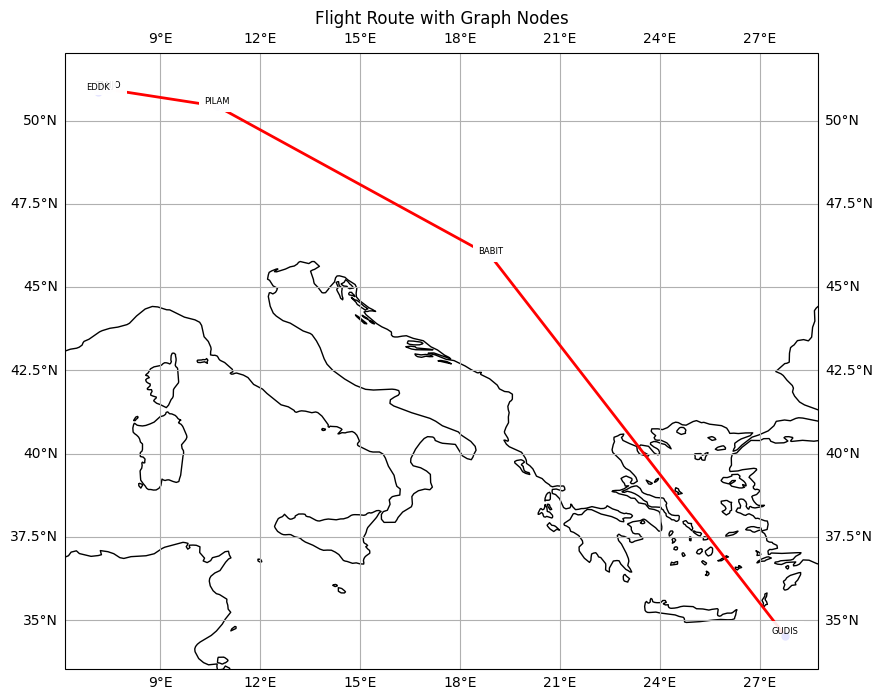

In [12]:
from utils.ploter import plot_route_with_graph_and_nodes_list_format
plot_route_with_graph_and_nodes_list_format(GC, real_waypoints, new_nodes)

# Batch Inference

In [22]:
import time
import math 
from infer_route5 import get_cell

cell_size = 0.5 
spatial_index = {}

if GC is not None:
    del GC
    GC = G.copy()

start_time = time.time()
# Build spatial index from existing graph nodes
for node, data in GC.nodes(data=True):
    if "lat" in data and "lon" in data:
        cell = get_cell(data["lat"], data["lon"], cell_size)
        if cell not in spatial_index:
            spatial_index[cell] = []
        spatial_index[cell].append((node, data["lat"], data["lon"]))
print(f'Spatial index built in {time.time() - start_time} seconds')

from infer_route5 import find_route
from tqdm import tqdm
from infer_route5 import haversine_distance

df_all_routes = pd.DataFrame(columns=['flight_id', 'real_waypoints', 'real_full_waypoints'])
df_synth_wps = pd.DataFrame(columns=['id', 'lat', 'lon'])

for flight_id in tqdm(flight_ids[:100]):

    selected_flight_df = routes_df[routes_df['id'] == flight_id]
    # Skip route inference if the flight has only one segment
    if len(selected_flight_df) <= 1:
        continue

    # Check route length and coordinates
    first_point = selected_flight_df.iloc[0]
    last_point = selected_flight_df.iloc[-1]
    
    # Calculate total route distance
    route_distance = haversine_distance(
        first_point['from_lat'], first_point['from_lon'], 
        last_point['to_lat'], last_point['to_lon']
    )
    
    # Skip route if total distance is less than 30 nautical miles
    if route_distance < 30:
        continue

    
    real_waypoints, real_full_waypoints, final_route, new_nodes = find_route(GC, selected_flight_df, error_threshold=25,
                                                                             distance_threshold_for_segment_skipping=25, max_wp_search_radius=12, min_wp_search_radius=3,
                                                                             spatial_index=spatial_index, cell_size=cell_size)
    df_all_routes = pd.concat([df_all_routes, pd.DataFrame({'flight_id': [flight_id],
                                                            'real_waypoints': ' '.join(real_waypoints),
                                                            'real_full_waypoints': ' '.join(real_full_waypoints),
                                                            })], ignore_index=True)
    # Add synthetic waypoints to df_synth_wps
    for node_id, node_data in new_nodes.items():
        df_synth_wps = pd.concat([df_synth_wps, pd.DataFrame({
            'id': [node_id],
            'lat': [node_data['lat']],
            'lon': [node_data['lon']]
        })], ignore_index=True)

Spatial index built in 0.02079319953918457 seconds


  1%|          | 1/100 [00:00<00:11,  8.56it/s]/var/folders/8k/_h2zg_z51q9fpsbmsh42bd3h0000gn/T/ipykernel_9408/563313619.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_synth_wps = pd.concat([df_synth_wps, pd.DataFrame({
100%|██████████| 100/100 [00:11<00:00,  9.06it/s]


In [24]:
df_all_routes.iloc[60:70]

,flight_id,real_waypoints,real_full_waypoints
60,0101BFMSC3723,METRU METRU_30 LFKD ARTAX BETOB RALIX OGLOT BAKUL,METRU METRU_30 LFKD ARTAX BETOB _LMHhYx5S RALI...
61,0101BFMSC3724,MOKUP BMC SALUN METRU_30,MOKUP BMC SALUN METRU_30
62,0101C8NIA7313,TANSA_98 METRU PECES_18 CJN_55 PDT LEMD,TANSA_98 METRU PECES_18 CJN_55 PDT LEMD
63,0101C8NIA7314,LETO RBO_16 VLC_58 DOBIX SALUN_66 METRU_30,LETO RBO_16 _0UNJc0Hp _D03tEZoc VLC_58 DOBIX S...
64,0101D3SUBTT,LFPB LFPA ABB TIPIL GOMUP ERAKA,LFPB LFPA _LzrcxtIF _S6SEkspA ABB TIPIL GOMUP ...
65,0101DBMSR799,GUDIS NIPIS GORAV SOSAD RENSA LORNI PODUK LFPG,GUDIS NIPIS GORAV SOSAD RENSA LORNI PODUK _eqv...
66,0101DBMSR800,LFPG LFPB LFPN LFPY KUVIV PIMAK DOBIM_77 LAPSO,LFPG LFPB LFPN LFPY KUVIV PIMAK DOBIM_77 _QO6m...
67,0101DCMSR780,LJLJ EBITI GUDIS,LJLJ EBITI GUDIS
68,0101DCMSR787,GUDIS NIPIS VAGEN AMDID DOSEL_61 DETEX EDDM,GUDIS NIPIS VAGEN AMDID DOSEL_61 DETEX EDDM
69,0101DCMSR788,EDDM BAVAX GUDIS,EDDM BAVAX _t4eyo6tZ GUDIS


In [15]:
df_synth_wps.head()

,id,lat,lon
0,_h8eAumN8,32.874027,32.250030
1,_i2RenOCG,33.102970,32.466618
2,_SBxN4nn3,34.419479,33.741816
3,_B14wUVEJ,34.554657,33.770908
4,_byp20YIn,34.752735,33.724537


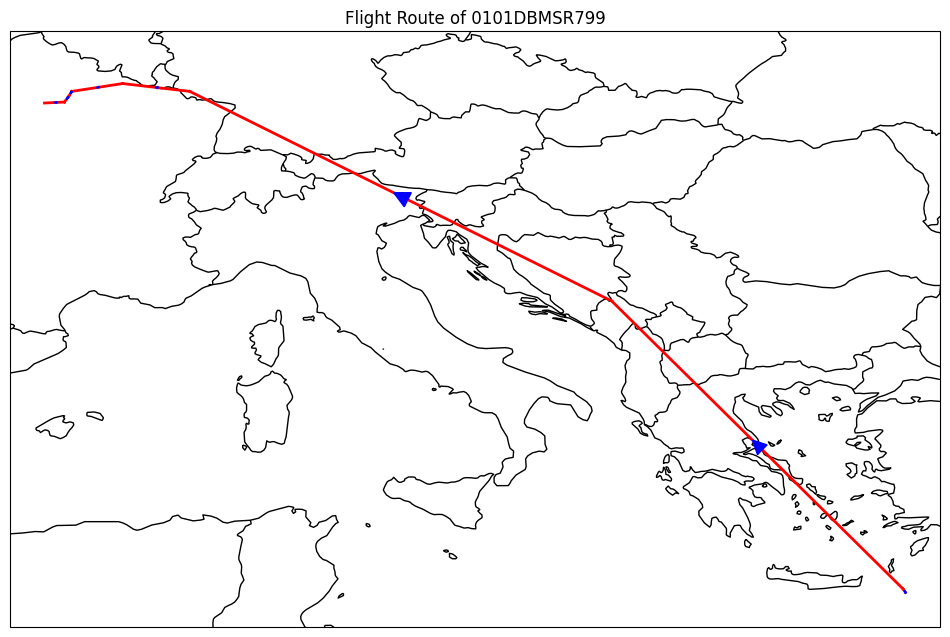

In [25]:
from utils.ploter import plot_route_of_flight
flight_id = '0101DBMSR799'
plot_route_of_flight(routes_df[routes_df['id'] == flight_id])

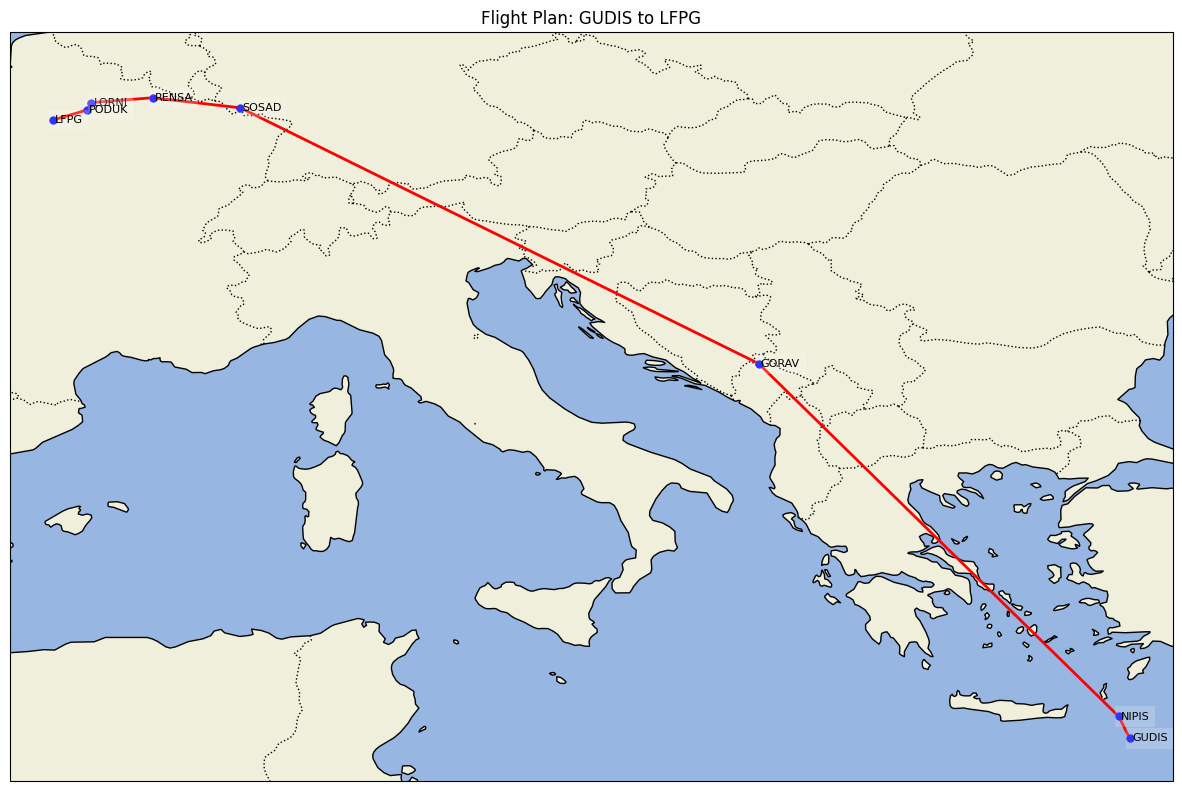

In [26]:
from utils.ploter import plot_flightplan2
plot_flightplan2(GC, df_all_routes[df_all_routes['flight_id'] == flight_id]['real_waypoints'].values[0].split(' '))

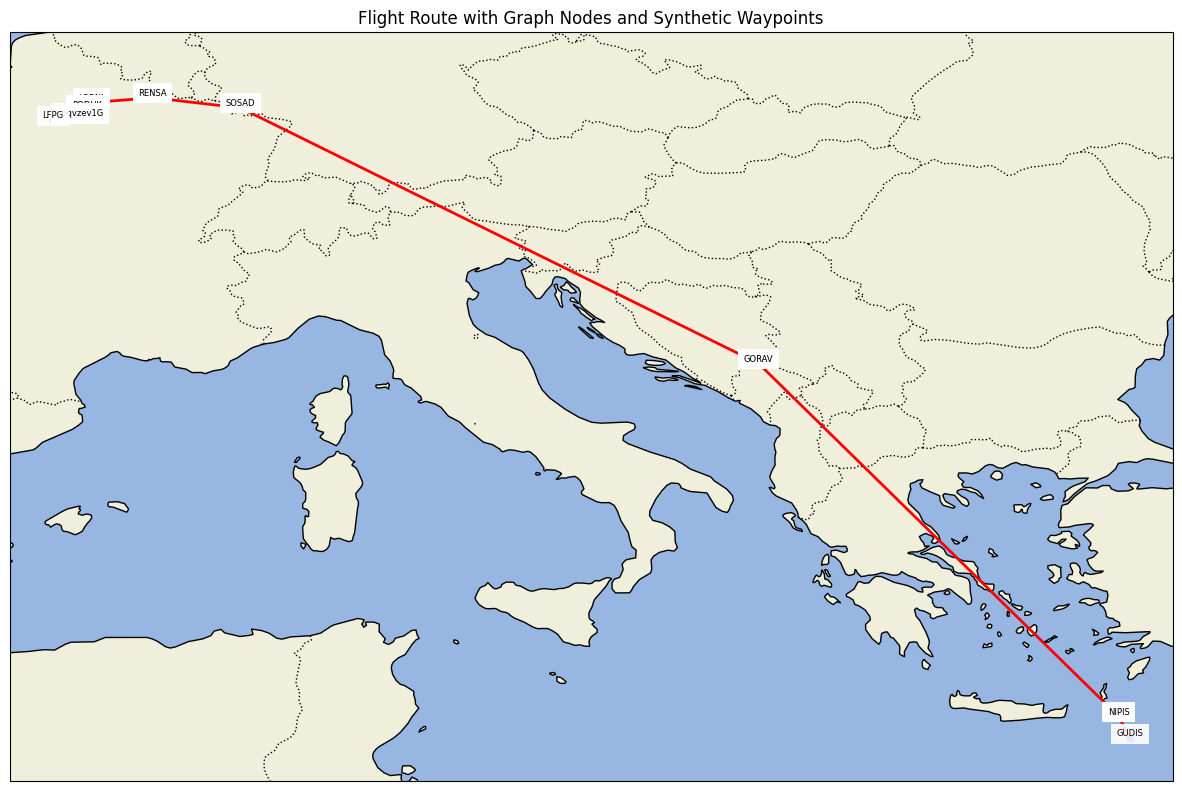

In [27]:
from utils.ploter import plot_route_with_graph_and_nodes_list_format_with_synth_wps
plot_route_with_graph_and_nodes_list_format_with_synth_wps(GC, df_all_routes[df_all_routes['flight_id'] == flight_id]['real_full_waypoints'].values[0], df_synth_wps)